In [1]:
# %matplotlib notebook
import tssearch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import novainstrumentation as ni

# CLS Dataset

### Activities

1. Walk
2. Walk upstairs
3. Walk downstairs
4. Walk 90$^\circ$-curve left
5. Walk 90$^\circ$-curve right
6. Spin left left-first
7. Spin left right-first
8. Spin right left-first
9. Spin right right-first
10. V-Cut left left-first
11. V-Cut left right-first
12. V-Cut right left-first
13. V-Cut right right-first
14. Shuffle left
15. Shuffle right
16. Run
17. Jump one leg 
18. Jump two legs
19. Sit
20. Stand
21. Sit down
22. Stand up

### Recording Channels

In [2]:
channels = {
0: "EMG1",
1: "EMG2",
2: "EMG3",
3: "EMG4",
4: "Airborne",
5: "ACC upper X",
6: "ACC upper Y",
7: "ACC upper Z",
8: "Goniometer X",
9: "ACC lower X",
10: "ACC lower Y",
11: "ACC lower Z",
12: "Goniometer Y",
13: "Gyro upper X",
14: "Gyro upper Y",
15: "Gyro upper Z",
16: "Gyro lower X",
17: "Gyro lower Y",
18: "Gyro lower Z"
}

In [3]:
dataset_dir = "/home/marilia/Downloads/csl_share_liu_et_al/"
user = "01"
activity = "01"

In [4]:
def goniometer_unit_conversion(data, vcc=3, n=16):
    return ((vcc / (2**n - 1)) * data - (vcc/2.)) / ((vcc/2 * 606 * 10**-5))

def accelerometer_unit_conversion(data, c_min=28000., c_max=38000.):
    return ((data - c_min) / (c_max - c_min)) * 2 - 1

### Load query and sequence

In [5]:
# load data
with h5py.File(dataset_dir + user + '/' + activity + '.h5', "r") as f:
    a_group_key = list(f.keys())[0]
    data = np.array(f[a_group_key])
    
taps = pd.read_csv("/home/marilia/Downloads/csl_share_liu_et_al/" + user + "/" + activity + ".csv", header=None)

In [6]:
# select query
idx = 0 
query = data[taps.loc[idx, 1]:taps.loc[idx, 2], :]

# select a short sequence
idx_start = 1
idx_end = 15
sequence = data[taps.loc[idx_start, 1]:taps.loc[idx_end, 1], :]

In [7]:
sequence = sequence.astype(float)
query = query.astype(float)

In [8]:
sequence[:, 9] = accelerometer_unit_conversion(sequence[:, 9])* 9.81
sequence[:, 10] = accelerometer_unit_conversion(sequence[:, 10])* 9.81
sequence[:, 11] = accelerometer_unit_conversion(sequence[:, 11]) * 9.81
sequence[:, 12] = goniometer_unit_conversion(sequence[:, 12], vcc=3, n=16)

query[:, 9] = accelerometer_unit_conversion(query[:, 9]) * 9.81
query[:, 10] = accelerometer_unit_conversion(query[:, 10]) * 9.81
query[:, 11] = accelerometer_unit_conversion(query[:, 11])* 9.81
query[:, 12] = goniometer_unit_conversion(query[:, 12], vcc=3, n=16)

### Time series visualization

In [9]:
# select channels' ID
sensor = [10, 12]

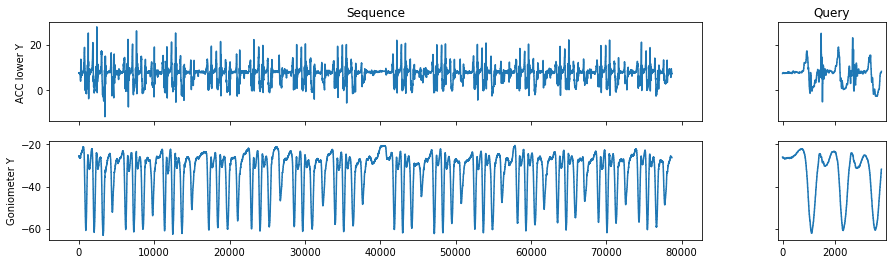

In [10]:
fig, axs = plt.subplots(len(sensor), 2, gridspec_kw={'width_ratios': [6, 1]}, sharey='row', sharex='col', figsize=(15,4))

for i, (ax, si) in enumerate(zip(axs.ravel(), np.array(sensor).repeat(2))):
    if i % 2 == 0:
        ax.plot(sequence[:, si])
        ax.set_ylabel(channels[si])
    else:
        ax.plot(query[:, si])
        
axs.ravel()[0].set_title('Sequence')
axs.ravel()[1].set_title('Query');

### Define distance configuration file

In [11]:
dict_distances = tssearch.get_distance_dict(["Dynamic Time Warping"])
dict_distances["elastic"]["Dynamic Time Warping"]["parameters"]["alpha"] = 0.5
dict_distances

{'elastic': {'Dynamic Time Warping': {'multivariate': 'yes',
   'description': '',
   'function': 'dtw',
   'parameters': {'dtw_type': 'dtw', 'alpha': 0.5},
   'use': 'yes'}}}

### Query search

In [ ]:
result = tssearch.time_series_search(dict_distances, query[:, sensor], sequence[:, sensor], output=("number", 14))

axs = tssearch.plot_search_distance_result(result, sequence[:, sensor])

for i in range(idx_start, idx_end):
    axs[0][1].vlines(taps.loc[i, 1] - taps.loc[idx_start, 1], np.max(sequence[:, sensor[1]]), np.min(sequence[:, sensor[1]]), 'g')
    axs[0][1].vlines(taps.loc[i, 2] - taps.loc[idx_start, 1], np.max(sequence[:, sensor[1]]), np.min(sequence[:, sensor[1]]), 'r')


## Segmentation

In [ ]:
ts_w = []
windows = []
for s, e in zip(result['Dynamic Time Warping']['start'], result['Dynamic Time Warping']['end']):
    windows += [sequence[s:e, sensor]]
    ts_w += [np.arange(len(windows[-1]))]

In [ ]:
cfg = tssearch.get_distances_by_type()
cfg['elastic']['Longest Common Subsequence']['parameters']['eps'] = 100

In [ ]:
# df = tssearch.time_series_distance_windows(cfg, query[:, sensor], windows[:3])

In [ ]:
# df

In [ ]:
ts = None
sequence = sequence[:, sensor]
query = query[:, sensor]

tq = np.arange(0, len(query)/1000, 1/1000)
res = result

In [ ]:
if ts is None:
    ts = np.arange(0, len(sequence)/1000, 1/1000)
# set distance scale
cmap = plt.cm.get_cmap('Greens')
colors = cmap(np.arange(cmap.N))

if len(np.shape(sequence)) > 1:
    sequence_shape = np.shape(sequence)[1]
else:
    sequence_shape = 1

all_axs = []
for k in res.keys():
    max_dist = np.max(res[k]["path_dist"])
    min_dist = np.min(res[k]["path_dist"])
    if max_dist == min_dist:
        max_dist += 1
        min_dist -= 1
    delta_dist = max_dist - min_dist

    fig, axs = plt.subplots(sequence_shape + 1, 2, gridspec_kw={'width_ratios': [1, 6]}, figsize=(7,4))
    axs[2,0].set_axis_off()
    for i in range(sequence_shape):
        plot_seq = sequence if sequence_shape == 1 else sequence[:, i]
        axs[i, 1].plot(ts, plot_seq, "lightgray")
        axs[i, 0].plot(tq, query[:, i], "gray")
        
        for s, e, d in zip(res[k]["start"], res[k]["end"], res[k]["path_dist"]):
            d_idx = int((d - min_dist) * cmap.N / delta_dist) - 1
            axs[i, 1].plot(ts[np.arange(s, e)], plot_seq[s:e], c=colors[d_idx])
        
        if i < sequence_shape - 2:
            axs[i, 0].sharex(axs[i + 1])
            axs[i, 0].set_xticks([])
            # 
    axs[sequence_shape, 1].set_xlabel("Distance")
    axs[sequence_shape, 1].imshow([colors], extent=[min_dist, max_dist, 0, 0.02 * delta_dist])
    axs[sequence_shape, 1].set_yticks([])
    axs[0, 0].set_ylabel('Acceleration / $m/s^2$')
    axs[1, 0].set_ylabel('Angle / $\degree$')
    axs[1, 0].set_xlabel('Time / $s$')
    axs[1, 1].set_xlabel('Time / $s$')
    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])
    axs[0,0].sharey(axs[0,1])
    axs[1,0].sharey(axs[1,1])
    
    all_axs += [axs]

plt.tight_layout()
fig.subplots_adjust(wspace=0.15,hspace=0.3)

plt.savefig('steps_example.pdf')